In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Math_6397/CH01

/content/drive/MyDrive/Math_6397/CH01


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

X = scipy.io.loadmat(os.path.join('..','DATA','VORTALL.mat'))
data=X['VORTALL']
a = 199 #width 
b = 449 #height

In [151]:
# coarsen library
n=data.shape[1]
clib=[]
lib=[]

for i in range(n):
  v= np.copy(np.real(np.reshape(data[:,i],(b,a))))
  coarse=np.resize(v,(22,9))
  clib=np.reshape(coarse,(198)).T
  lib.append(clib)

lib=np.reshape(lib,(198,151))

In [61]:
def plotFlow(X,b,a):    
    ## Plot Mode 2
    vortmin = -5
    vortmax = 5
    V2 = np.copy(np.real(np.reshape(X,(b,a))))
    V2 = V2.T

    # normalize values... not symmetric
    minval = np.min(V2)
    maxval = np.max(V2)

    if np.abs(minval) < 5 and np.abs(maxval) < 5:
        if np.abs(minval) > np.abs(maxval):
            vortmax = maxval
            vortmin = -maxval
        else:
            vortmin = minval
            vortmax = -minval

    V2[V2 > vortmax] = vortmax
    V2[V2 < vortmin] = vortmin

    plt.imshow(V2,cmap='jet',vmin=vortmin,vmax=vortmax)

    cvals = np.array([-4,-2,-1,-0.5,-0.25,-0.155])
    plt.contour(V2,cvals*vortmax/5,colors='k',linestyles='dashed',linewidths=1)
    plt.contour(V2,np.flip(-cvals)*vortmax/5,colors='k',linestyles='solid',linewidths=0.4)

    plt.scatter(49*b/449,99*a/199,5000,color='k') # draw cylinder

    #plt.show()

In [62]:
import imageio
def createMovie(X,b,a):
    plt.rcParams['figure.figsize'] = [8, 8]
    filenames = []
    for i in range(150):
        plotFlow(X[:,i],b,a)
        filename = './pics/full'+str(i)+'.png'
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()
    with imageio.get_writer('vortices.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.v2.imread(filename)
            writer.append_data(image)
    for filename in set(filenames):
        os.remove(filename)

FileNotFoundError: ignored

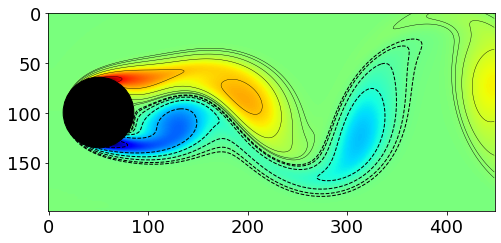

In [63]:
#movie of original flow field
createMovie(data,449,199)

FileNotFoundError: ignored

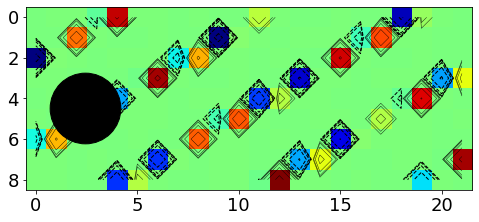

In [67]:
#movie of flow field in new coordinates
createMovie(lib,22,9)

Text(0.5, 1.0, 'Reconstruct estimated fluid flow of column=99')

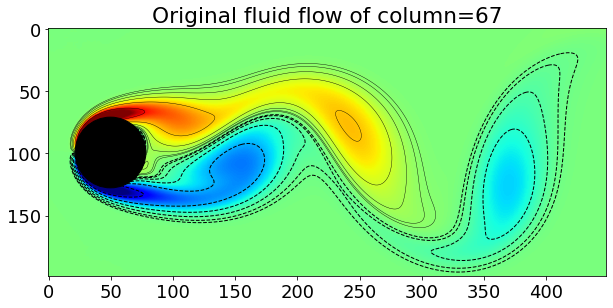

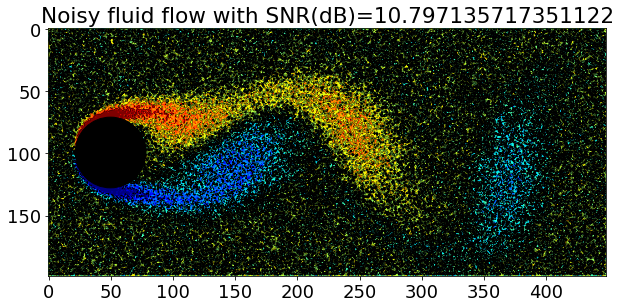

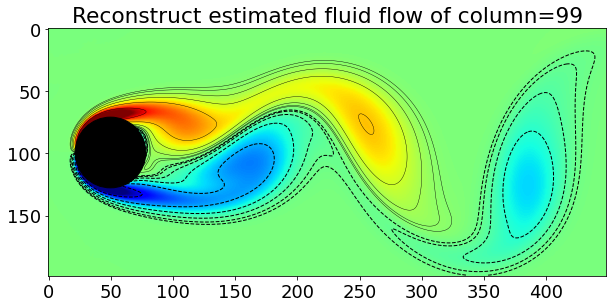

In [152]:
#pick a column of full field and add noise, downsample
from random import *
import statistics
import pandas as pd
import math

cp=randint(0,150)
data1=data[:,cp]
noise=np.random.randn(data1.shape[0])
datan=data1+noise
snr1=math.log(np.mean(data1**2/noise**2));

c2=[]
lib2=[]
std=[]

v2=np.copy(np.real(np.reshape(datan,(b,a)))) #noisy flow fuild
coarse2=np.resize(v2,(22,9))
c2=np.reshape(coarse,(198)).T

for i in range(150):
  e= np.linalg.norm(lib[:,i]-c2)/np.linalg.norm(lib[:,i])
  std.append(e)

idx=pd.Series(std).idxmin()
recons_estimate=data[:,idx]


vr= np.copy(np.real(np.reshape(data[:,idx],(b,a))))  #reconstructed flow field
v0=np.copy(np.real(np.reshape(data1,(b,a))))  #original flow fluid

plt.figure()
plotFlow(v0,449,199)
plt.title('Original fluid flow of column='+str(cp))
plt.figure()
plotFlow(v2,449,199)
plt.title('Noisy fluid flow with SNR(dB)='+str(snr1))
plt.figure()
plotFlow(vr,449,199)
plt.title('Reconstruct estimated fluid flow of column='+str(idx))


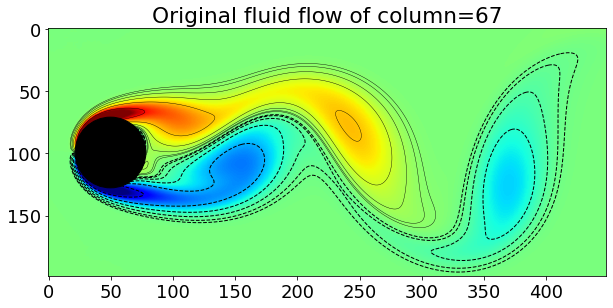

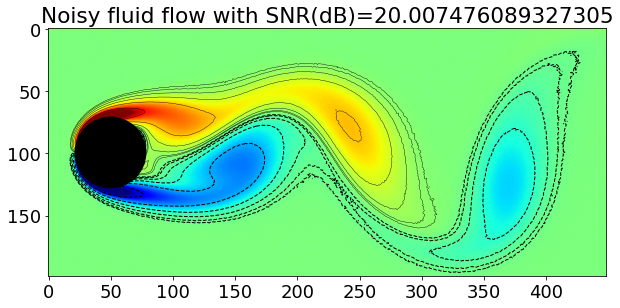

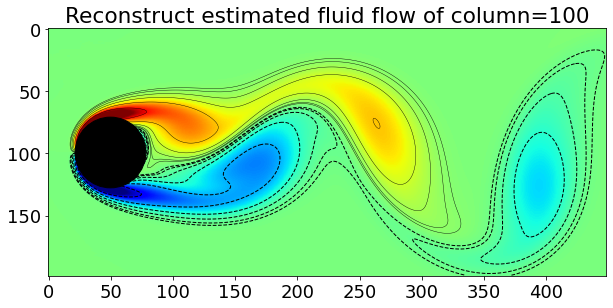

In [158]:
#with different noise
plt.figure()
plotFlow(v0,449,199)
plt.title('Original fluid flow of column='+str(cp))


for k in [0.01]:
  datan=data1+k*noise
  snr1=math.log(np.mean(data1**2/(k*noise)**2));
  c2=[]
  lib2=[]
  avg=[]
  v2=np.copy(np.real(np.reshape(datan,(b,a)))) #noisy flow fuild
  coarse2=np.resize(v2,(22,9))
  c2=np.reshape(coarse,(198)).T
  
  for i in range(150):
    e= np.linalg.norm(lib[:,i]-c2,ord=2)/np.linalg.norm(lib[:,i],ord=1)
    avg.append(e)
    
  idx=pd.Series(avg).idxmin()
  recons_estimate=data[:,idx]
  
  vr= np.copy(np.real(np.reshape(data[:,idx],(b,a))))  #reconstructed flow field
  
  plt.figure()
  plotFlow(v2,449,199)
  plt.title('Noisy fluid flow with SNR(dB)='+str(snr1))
  plt.figure()
  plotFlow(vr,449,199)
  plt.title('Reconstruct estimated fluid flow of column='+str(idx))


In [ ]:
, 0.1, 0.5, 1.5, 5 ,10

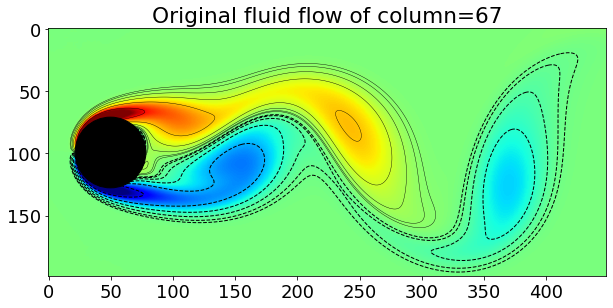

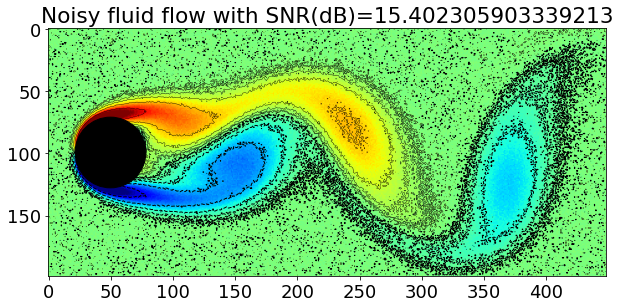

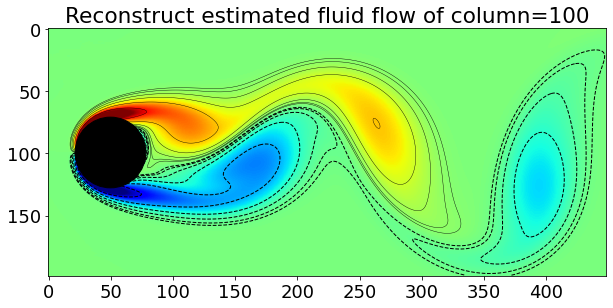

In [159]:
plt.figure()
plotFlow(v0,449,199)
plt.title('Original fluid flow of column='+str(cp))


for k in [0.1]:
  datan=data1+k*noise
  snr1=math.log(np.mean(data1**2/(k*noise)**2));
  c2=[]
  lib2=[]
  avg=[]
  v2=np.copy(np.real(np.reshape(datan,(b,a)))) #noisy flow fuild
  coarse2=np.resize(v2,(22,9))
  c2=np.reshape(coarse,(198)).T
  
  for i in range(150):
    e= np.linalg.norm(lib[:,i]-c2,ord=2)/np.linalg.norm(lib[:,i],ord=1)
    avg.append(e)
    
  idx=pd.Series(avg).idxmin()
  recons_estimate=data[:,idx]
  
  vr= np.copy(np.real(np.reshape(data[:,idx],(b,a))))  #reconstructed flow field
  
  plt.figure()
  plotFlow(v2,449,199)
  plt.title('Noisy fluid flow with SNR(dB)='+str(snr1))
  plt.figure()
  plotFlow(vr,449,199)
  plt.title('Reconstruct estimated fluid flow of column='+str(idx))

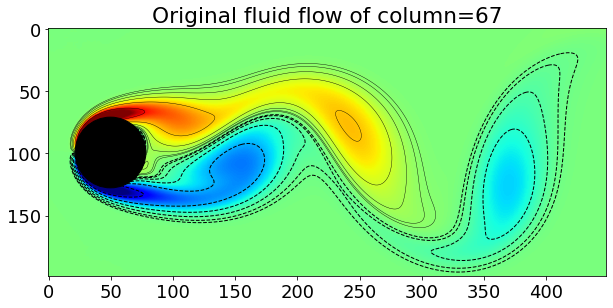

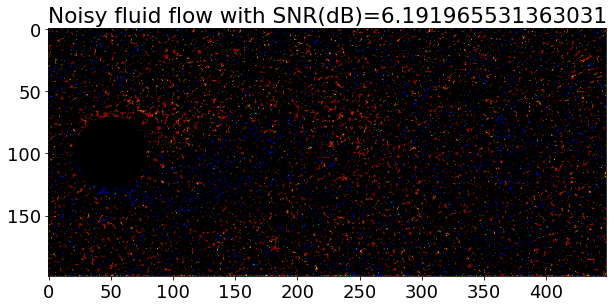

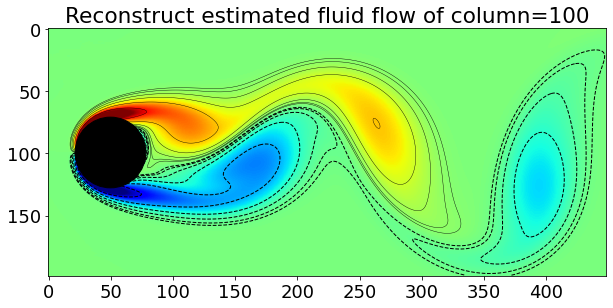

In [160]:
plt.figure()
plotFlow(v0,449,199)
plt.title('Original fluid flow of column='+str(cp))


for k in [10]:
  datan=data1+k*noise
  snr1=math.log(np.mean(data1**2/(k*noise)**2));
  c2=[]
  lib2=[]
  avg=[]
  v2=np.copy(np.real(np.reshape(datan,(b,a)))) #noisy flow fuild
  coarse2=np.resize(v2,(22,9))
  c2=np.reshape(coarse,(198)).T
  
  for i in range(150):
    e= np.linalg.norm(lib[:,i]-c2,ord=2)/np.linalg.norm(lib[:,i],ord=1)
    avg.append(e)
    
  idx=pd.Series(avg).idxmin()
  recons_estimate=data[:,idx]
  
  vr= np.copy(np.real(np.reshape(data[:,idx],(b,a))))  #reconstructed flow field
  
  plt.figure()
  plotFlow(v2,449,199)
  plt.title('Noisy fluid flow with SNR(dB)='+str(snr1))
  plt.figure()
  plotFlow(vr,449,199)
  plt.title('Reconstruct estimated fluid flow of column='+str(idx))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


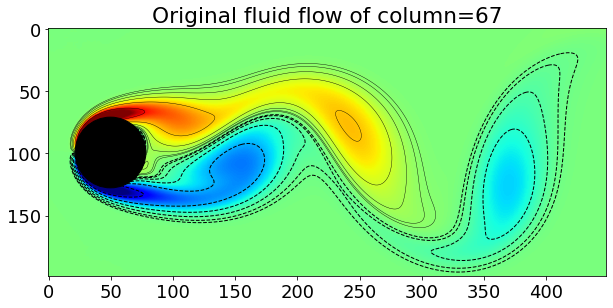

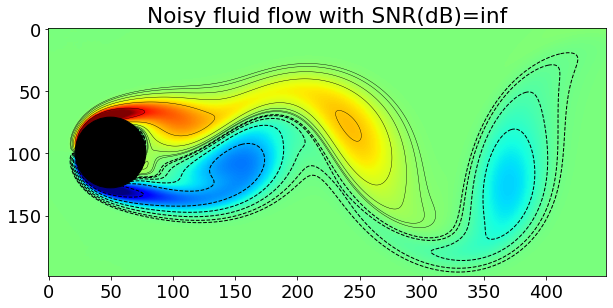

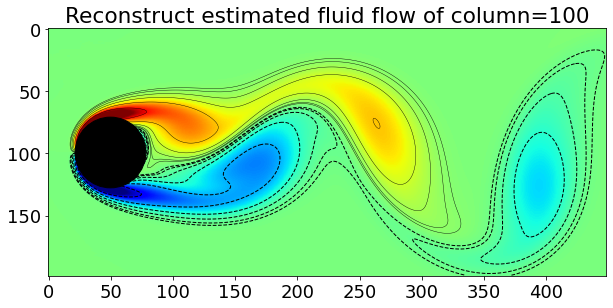

In [161]:
plt.figure()
plotFlow(v0,449,199)
plt.title('Original fluid flow of column='+str(cp))


for k in [0]:
  datan=data1+k*noise
  snr1=math.log(np.mean(data1**2/(k*noise)**2));
  c2=[]
  lib2=[]
  avg=[]
  v2=np.copy(np.real(np.reshape(datan,(b,a)))) #noisy flow fuild
  coarse2=np.resize(v2,(22,9))
  c2=np.reshape(coarse,(198)).T
  
  for i in range(150):
    e= np.linalg.norm(lib[:,i]-c2,ord=2)/np.linalg.norm(lib[:,i],ord=1)
    avg.append(e)
    
  idx=pd.Series(avg).idxmin()
  recons_estimate=data[:,idx]
  
  vr= np.copy(np.real(np.reshape(data[:,idx],(b,a))))  #reconstructed flow field
  
  plt.figure()
  plotFlow(v2,449,199)
  plt.title('Noisy fluid flow with SNR(dB)='+str(snr1))
  plt.figure()
  plotFlow(vr,449,199)
  plt.title('Reconstruct estimated fluid flow of column='+str(idx))


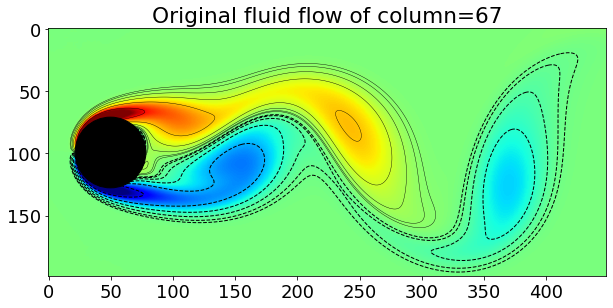

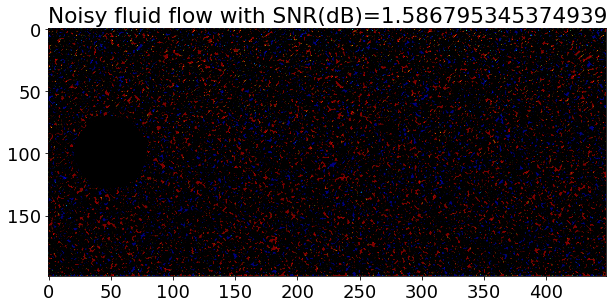

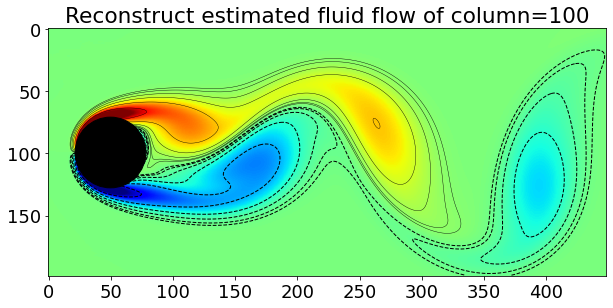

In [162]:
plt.figure()
plotFlow(v0,449,199)
plt.title('Original fluid flow of column='+str(cp))


for k in [100]:
  datan=data1+k*noise
  snr1=math.log(np.mean(data1**2/(k*noise)**2));
  c2=[]
  lib2=[]
  avg=[]
  v2=np.copy(np.real(np.reshape(datan,(b,a)))) #noisy flow fuild
  coarse2=np.resize(v2,(22,9))
  c2=np.reshape(coarse,(198)).T
  
  for i in range(150):
    e= np.linalg.norm(lib[:,i]-c2,ord=2)/np.linalg.norm(lib[:,i],ord=1)
    avg.append(e)
    
  idx=pd.Series(avg).idxmin()
  recons_estimate=data[:,idx]
  
  vr= np.copy(np.real(np.reshape(data[:,idx],(b,a))))  #reconstructed flow field
  
  plt.figure()
  plotFlow(v2,449,199)
  plt.title('Noisy fluid flow with SNR(dB)='+str(snr1))
  plt.figure()
  plotFlow(vr,449,199)
  plt.title('Reconstruct estimated fluid flow of column='+str(idx))


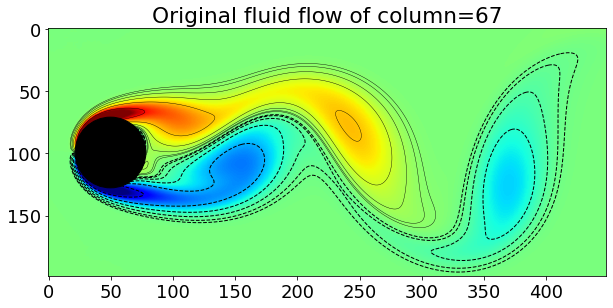

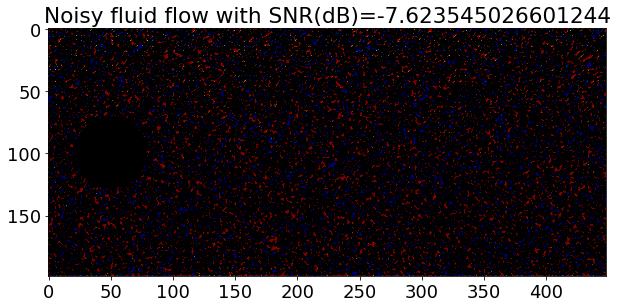

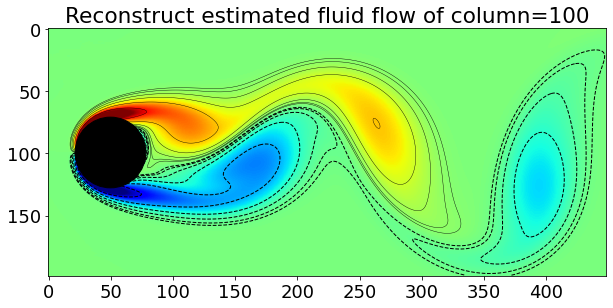

In [163]:
plt.figure()
plotFlow(v0,449,199)
plt.title('Original fluid flow of column='+str(cp))


for k in [10000]:
  datan=data1+k*noise
  snr1=math.log(np.mean(data1**2/(k*noise)**2));
  c2=[]
  lib2=[]
  avg=[]
  v2=np.copy(np.real(np.reshape(datan,(b,a)))) #noisy flow fuild
  coarse2=np.resize(v2,(22,9))
  c2=np.reshape(coarse,(198)).T
  
  for i in range(150):
    e= np.linalg.norm(lib[:,i]-c2,ord=2)/np.linalg.norm(lib[:,i],ord=1)
    avg.append(e)
    
  idx=pd.Series(avg).idxmin()
  recons_estimate=data[:,idx]
  
  vr= np.copy(np.real(np.reshape(data[:,idx],(b,a))))  #reconstructed flow field
  
  plt.figure()
  plotFlow(v2,449,199)
  plt.title('Noisy fluid flow with SNR(dB)='+str(snr1))
  plt.figure()
  plotFlow(vr,449,199)
  plt.title('Reconstruct estimated fluid flow of column='+str(idx))
